# Import packages

In [1]:
import pandas as pd
import numpy as np
import os
from anndata import read_h5ad
from sklearn.neighbors import NearestNeighbors


import warnings
warnings.filterwarnings('ignore')
import sys

# sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('../../utils/')
from annotations_utils import *
import scvi
print(scvi.__version__)

import os
os.getcwd()

import logging
import os
import pickle
from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer, SemiSupervisedTrainer
from scvi.models import VAE, SCANVI
from copy import deepcopy

from scvi.dataset.anndataset import AnnDatasetFromAnnData

import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

n_epochs = 150
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=True


sc.logging.print_versions()

[2020-02-13 12:00:09,627] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


0.5.0
scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Load data

In [29]:
data_path = '../../data-objs/pilot1/FinalAnnotation/'

In [30]:
import os
os.listdir(data_path)

['CombineCompartments.scANVI.lung.scanpy_norm.h5ad',
 '.ipynb_checkpoints',
 'CombineCompartments.scANVI.endopancreas.mixed.imputed.h5ad',
 'CombineCompartments.scANVI.blood.imputed.h5ad',
 'CombineCompartments.scANVI.exopancreas1.Immune.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.stromal.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.Pancreas.Stromal.imputed.h5ad',
 'CombineCompartments.scANVI.bladder.count.h5ad',
 'CombineCompartments.scANVI.pancreas_all.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.pancreas.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.bladder.mixed.imputed.h5ad',
 'CombineCompartments.scANVI.endopancreas.Immune.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.exopancreas2.count.h5ad',
 'CombineCompartments.scANVI.Bladder.mixed.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.PancreasEndocrine.Immune.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.Pancreas.Stromal.scanpy_norm.h5ad',
 'CombineCompartments.scANVI.Bladder.Endothelial.imputed.h5ad',
 'CombineComp

In [36]:
adata = read_h5ad(data_path+'CombineCompartments.scANVI.all.h5ad')
adata

AnnData object with n_obs × n_vars = 68451 × 21301 
    obs: 'Tissue Tech', '10X_plate', 'Manual Annotation Round 2', 'scANVI Prediction By Organ', 'n_genes', 'tissue', 'leiden_scvi', 'leiden_scvi_split', 'Compartment', 'scANVI Prediction By Organ-Compartment', 'scANVI Prediction By Organ with Alternate Training', 'scANVI Prediction By Organ-Compartment with Alternate Training', 'batch_id', 'S_score', 'G2M_score', 'phase', 'scANVI Prediction Ontology Term By Organ', 'scANVI Prediction Ontology Term By Organ with Alternate Training', 'scANVI Prediction Ontology Term By Organ-Compartment', 'scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training', 'Manual Annotation Round 2 Ontology Terms', 'log1p_total_counts'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [32]:
adata.obs

,Tissue Tech,10X_plate,Manual Annotation Round 2,scANVI Prediction By Organ,n_genes,tissue,leiden_scvi,leiden_scvi_split,Compartment,scANVI Prediction By Organ-Compartment,...,batch_id,S_score,G2M_score,phase,scANVI Prediction Ontology Term By Organ,scANVI Prediction Ontology Term By Organ with Alternate Training,scANVI Prediction Ontology Term By Organ-Compartment,scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training,Manual Annotation Round 2 Ontology Terms,log1p_total_counts
index,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGCATCCCG-1-0,endopancreas_10x,1,unassigned,pancreatic ductal cell,500,Pancreas,4,6,Epithelial,pancreatic ductal cell,...,8,0.001789,-0.030600,S,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,cell,6.467699
AAAGGATTCTCGCCTA-1-0,endopancreas_10x,1,unassigned,pancreatic acinar cell,384,Pancreas,0,2,mixed,pancreatic acinar cell,...,8,0.012151,-0.150551,S,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,cell,7.651596
AAAGGGCGTGGGCTCT-1-0,endopancreas_10x,1,pancreatic acinar cell,pancreatic acinar cell,215,Pancreas,2,0,Stromal,pancreatic acinar cell,...,8,-0.009067,-0.154223,G1,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,7.617760
AACAAAGTCGAAGCCC-1-0,endopancreas_10x,1,pancreatic acinar cell,pancreatic acinar cell,343,Pancreas,4,3,Epithelial,pancreatic acinar cell,...,8,-0.009067,-0.035337,G1,pancreatic acinar cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic ductal cell,pancreatic acinar cell,6.666957
AACAACCTCAACGAGG-1-0,endopancreas_10x,1,endothelial cell,endothelial cell,1590,Pancreas,7,7,mixed,endothelial cell,...,8,-0.002406,-0.102339,G1,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,8.036250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B107925_P2_S3.homo,Blood_ss2,nan,unassigned,natural killer cell,1393,Blood,nan,nan,Immune,natural killer cell,...,1,79.268135,-34.982342,S,natural killer cell,natural killer cell,natural killer cell,natural killer cell,cell,13.859382
B107925_P3_S4.homo,Blood_ss2,nan,unassigned,"naive thymus-derived CD4-positive, alpha-beta ...",1058,Blood,nan,nan,Immune,"naive thymus-derived CD4-positive, alpha-beta ...",...,1,-25.447693,15.993858,G2M,"naive thymus-derived CD4-positive, alpha-beta ...","naive thymus-derived CD4-positive, alpha-beta ...","naive thymus-derived CD4-positive, alpha-beta ...","naive thymus-derived CD4-positive, alpha-beta ...",cell,14.054719
B107925_P4_S5.homo,Blood_ss2,nan,unassigned,erythrocyte,1278,Blood,nan,nan,Immune,erythrocyte,...,1,-34.473972,-32.007343,G1,erythrocyte,"CD4-positive, alpha-beta memory T cell",erythrocyte,"CD4-positive, alpha-beta memory T cell",cell,14.033640


In [ ]:
adata10X =

In [3]:
adata = read_h5ad(data_path+'CombineCompartments.scANVI.all.imputed.h5ad')
adata

AnnData object with n_obs × n_vars = 68451 × 21301 
    obs: 'Pancreas Prediction', 'Compartment Prediction', 'Tissue Tech', '10X_plate', 'Manual Annotation Round 2', 'scANVI Prediction By Organ', 'Compartment', 'scANVI Prediction By Organ-Compartment', 'tissue', 'scANVI Prediction By Organ with Alternate Training', 'scANVI Prediction By Organ-Compartment with Alternate Training', 'batch_id', 'Smoothed Compartment Prediction', 'S_score', 'G2M_score', 'phase', 'scANVI Prediction Ontology Term By Organ', 'scANVI Prediction Ontology Term By Organ with Alternate Training', 'scANVI Prediction Ontology Term By Organ-Compartment', 'scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training', 'Manual Annotation Round 2 Ontology Terms', 'n_genes', 'log1p_total_counts', 'leiden'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'Compartment Prediction_colors', 'Pancreas Prediction_colors', 'Smoothed Compartment Prediction_colors', 'leiden', 'neighbors', 'smooth_comp2_colors', 'smooth_

In [37]:
adata.obs['tissue'] = adata.obs['tissue'].str.lower()
adata.obs['subtissue'] = adata.obs['tissue']
adata.obs.loc[adata.obs['tissue'].isin(
    ['exopancreas1','endopancreas','exopancreas2','pancreasendocrine', 'pancreasexocrine']),'tissue'] = 'pancreas'

adata.obs['method'] = [tt.split('_')[1] for tt in adata.obs['Tissue Tech']]

# adata.obs = adata.obs.drop(
#     ['Compartment Prediction', '10X_plate','Compartment', 'S_score', 'G2M_score', 'phase'],
#     axis=1)

adata.obs = adata.obs.rename(columns={"Tissue Tech": "tissue_method",
                                      "Pancreas Prediction" : "pancreas_prediction",
                                     "Manual Annotation Round 2": "manual_free_annotation",
                                     "Manual Annotation Round 2 Ontology Terms": "manual_cell_ontology",
                                     "Smoothed Compartment Prediction": "compartment_prediction",
                                     "scANVI Prediction By Organ": "scANVI_organ_free_annotation",
                                     "scANVI Prediction By Organ-Compartment": "scANVI_organ_compartment_free_annotation",
                                     "scANVI Prediction By Organ with Alternate Training": "scANVI_organ_alternate_training_free_annotation",
                                     "scANVI Prediction By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_free_annotation",
                                     "scANVI Prediction Ontology Term By Organ": "scANVI_organ_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment": "scANVI_organ_compartment_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ with Alternate Training": "scANVI_organ_alternate_training_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_cell_ontology"})

# adata.obs['compartment_prediction'] = adata.obs['compartment_prediction'].str.lower()

adata.obs = adata.obs.reindex(sorted(adata.obs.columns), axis=1)

adata

AnnData object with n_obs × n_vars = 68451 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [40]:
adata.obs['method']

index
AAACGAAAGCATCCCG-1-0    10x
AAAGGATTCTCGCCTA-1-0    10x
AAAGGGCGTGGGCTCT-1-0    10x
AACAAAGTCGAAGCCC-1-0    10x
AACAACCTCAACGAGG-1-0    10x
                       ... 
B107925_P2_S3.homo      ss2
B107925_P3_S4.homo      ss2
B107925_P4_S5.homo      ss2
B107925_P6_S7.homo      ss2
B107925_P9_S10.homo     ss2
Name: method, Length: 68451, dtype: object

In [41]:
adata10X = adata[adata.obs['method']=='10x'].copy()
adata10X

AnnData object with n_obs × n_vars = 64367 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [47]:
adata10X.X[1000:2000,1000:2000].todense()

matrix([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
sc.pp.filter_cells(adata10X,min_counts=0)
sc.pp.filter_cells(adata10X,min_genes=0)
adata10X

AnnData object with n_obs × n_vars = 64367 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method', 'n_counts'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [49]:
import seaborn as sns

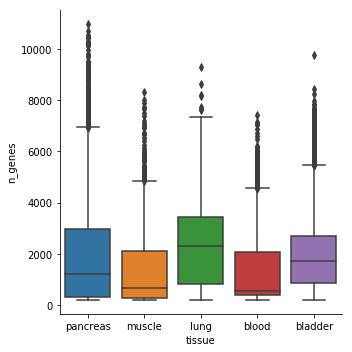

In [58]:
sns.catplot(data = adata10X.obs, x = 'tissue', y='n_genes',kind='box')

In [5]:
set(adata.obs['pancreas_prediction']),set(adata.obs['compartment_prediction'])

({'not pancreas', 'pancreas'},
 {'endothelial', 'epithelial', 'immune', 'mixed', 'stromal'})

In [6]:
adata.obs.head()

,batch_id,compartment_prediction,leiden,log1p_total_counts,manual_cell_ontology,manual_free_annotation,method,n_genes,pancreas_prediction,scANVI_organ_alternate_training_cell_ontology,scANVI_organ_alternate_training_free_annotation,scANVI_organ_cell_ontology,scANVI_organ_compartment_alternate_training_cell_ontology,scANVI_organ_compartment_alternate_training_free_annotation,scANVI_organ_compartment_cell_ontology,scANVI_organ_compartment_free_annotation,scANVI_organ_free_annotation,subtissue,tissue,tissue_method
index,,,,,,,,,,,,,,,,,,,,
AAACGAAAGCATCCCG-1-0,8,epithelial,63,6.467699,cell,unassigned,10x,500,not pancreas,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,endopancreas,pancreas,endopancreas_10x
AAAGGATTCTCGCCTA-1-0,8,epithelial,25,7.651596,cell,unassigned,10x,384,pancreas,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AAAGGGCGTGGGCTCT-1-0,8,mixed,15,7.617760,pancreatic acinar cell,pancreatic acinar cell,10x,215,pancreas,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AACAAAGTCGAAGCCC-1-0,8,epithelial,48,6.666957,pancreatic acinar cell,pancreatic acinar cell,10x,343,pancreas,pancreatic ductal cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AACAACCTCAACGAGG-1-0,8,endothelial,64,8.036250,endothelial cell,endothelial cell,10x,1590,not pancreas,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endopancreas,pancreas,endopancreas_10x


# Write objs for browser

In [7]:
adata.write('../../data-objs/pilot1/TSP1_objs_browser/TSP1_all.h5ad')

... storing 'compartment_prediction' as categorical
... storing 'method' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical


## Write compartment objs

In [8]:
for c in list(set(adata.obs['compartment_prediction'])):
    adata_comp = adata[adata.obs['compartment_prediction']==c].copy()
    
    if adata_comp.shape[0]>0:
        sc.pp.pca(adata_comp)
        sc.pp.neighbors(adata_comp, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
        sc.tl.umap(adata_comp)
        sc.tl.leiden(adata_comp)
        sc.tl.tsne(adata_comp, use_rep = 'X_scvi')
        adata_comp.write_h5ad('../../data-objs/pilot1/TSP1_objs_browser/TSP1_all_'+c+'.h5ad')
    else:
        print("there is no cells to put in "+c)

computing PCA with n_comps = 50
    finished (0:00:10)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)
running Leiden clustering
    finished: found 35 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)
computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:03:15)
computing PCA with n_comps = 50
    finished (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden',

## Write tissue objs

In [9]:
for t in list(set(adata.obs['tissue'])):
    adata_tiss = adata[adata.obs['tissue']==t].copy()
    
    if adata_tiss.shape[0]>0:
        sc.pp.pca(adata_tiss)
        sc.pp.neighbors(adata_tiss, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
        sc.tl.umap(adata_tiss)
        sc.tl.leiden(adata_tiss)
        sc.tl.tsne(adata_tiss, use_rep = 'X_scvi')
        adata_tiss.write_h5ad('../../data-objs/pilot1/TSP1_objs_browser/TSP1_'+t+'.h5ad')
    else:
        print("there is no cells to put in "+t)

computing PCA with n_comps = 50
    finished (0:00:07)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:51)
computing PCA with n_comps = 50
    finished (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden',

## Write tissue_compartment objs

In [25]:
for t in ['blood','pancreas']:#list(set(adata.obs['tissue'])):
    adata_tiss = adata[adata.obs['tissue']==t].copy()
    if adata_tiss.shape[0]>0:
        
        for c in list(set(adata_tiss.obs['compartment_prediction'])):
            adata_comp = adata_tiss[adata_tiss.obs['compartment_prediction']==c].copy()

            if adata_comp.shape[0]>0:
                
                try:
                    sc.pp.pca(adata_comp)
                except:
                    sc.pp.pca(adata_comp,n_comps=adata_comp.shape[0]-1)
                
                sc.pp.neighbors(adata_comp, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
                
                try:
                    sc.tl.umap(adata_comp)
                    sc.tl.leiden(adata_comp)
                    sc.tl.tsne(adata_comp, use_rep = 'X_scvi')
                    adata_comp.write_h5ad('../../data-objs/pilot1/TSP1_objs_browser/TSP1_'+t+'_'+c+'.h5ad')
                
                except:
                    print("there is no cells to put in "+t+" "+c)
            
            else:
                print("there is no cells to put in "+t+" "+c)
    
    
    else:
        print("there is no cells to put in "+t)

computing PCA with n_comps = 50
    finished (0:00:07)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:46)
computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', 